## **Homework-3: Multiclass semantic segmentation on road images**

* Use the shared python notebook from the semantic segmentation lecture (CENG506_Multiclass_Semantic_Segmentation.ipynb)

* You will be using the dataset given as attachment (12 MB). Dataset has 265 images and same number of mask images (160x120 resolution). Mask images contain class ID for each pixel at the last (third) channel. Please figure out how many classes there are by yourselves.

* Divide the dataset as train and validation by yourselves.

* You may need to change/decide on the number of encoder and decoder blocks in your U-Net, as well as number of filters at each block.

* You are supposed to decide on hyperparameters (CNN architecture, batch size etc) but you do not have to show comparison results about hyperparameters, just come up with a set of hyperparameters that work well. Train for 50+ epochs and plot your training curves. Your training and validation loss should decrease and training and validation accuracy should increase.

* Please also report MeanIoU on the test set as we did in the lecture python notebook (CENG506_Multiclass_Semantic_Segmentation.ipynb).

* For reference, I reached 98% train accuracy, 96% test accuracy and 0.60 test set mIoU. But you do not have to reach these numbers. Priority is that your training goes well.

<h1>Preparation and Dataset Introduction</h1>

In [134]:
from keras.utils import normalize, set_random_seed
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

In [135]:
SIZE_X = 160
SIZE_Y = 120
n_classes = 22 #Number of classes for segmentation
my_seed = 23
set_random_seed(my_seed)

In [138]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [137]:
image_names = glob.glob("/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/*.png")
mask_names = glob.glob("/content/drive/MyDrive/CENG506_HW3/CameraMask160x120/*.png")
print(image_names)
print(mask_names)

['/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/008812.png', '/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/004063.png', '/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/007777.png', '/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/007351.png', '/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/002297.png', '/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/003884.png', '/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/002718.png', '/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/001905.png', '/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/006891.png', '/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/008051.png', '/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/008828.png', '/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/003848.png', '/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/008098.png', '/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/004075.png', '/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/002324.png', '/content

We have to sort the list because glob function doesn't read them in a sorted way

In [139]:
image_names_sorted = sorted(image_names)
mask_names_sorted = sorted(mask_names)
print(len(image_names_sorted))
print(len(mask_names_sorted))
print(image_names_sorted)
print(mask_names_sorted)

265
265
['/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/000029.png', '/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/000043.png', '/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/000084.png', '/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/000689.png', '/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/000694.png', '/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/001888.png', '/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/001892.png', '/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/001898.png', '/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/001905.png', '/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/001918.png', '/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/001936.png', '/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/001960.png', '/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/002108.png', '/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/002112.png', '/content/drive/MyDrive/CENG506_HW3/CameraRGB160x120/002116.png', '

When we look at the masks we can see that they are encoded in the red channel, therefore we have to extract them from the red channel.

In [140]:
images = [cv2.imread(image, cv2.IMREAD_COLOR) for image in image_names_sorted]
image_dataset = np.array(images)

# read mask images and extract the red channel
masks = [cv2.imread(mask, cv2.IMREAD_COLOR) for mask in mask_names_sorted]
mask_dataset = np.array([mask[:, :, 2] for mask in masks])

In [141]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (265, 120, 160, 3)
Mask data shape is:  (265, 120, 160)
Max pixel value in image is:  255
Labels in the mask are :  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


**As it can be seen above, there are 22 distinct labels which means there are 22 classes.**

I am displaying an example image in our dataset and its mask to see what the dataset is like.

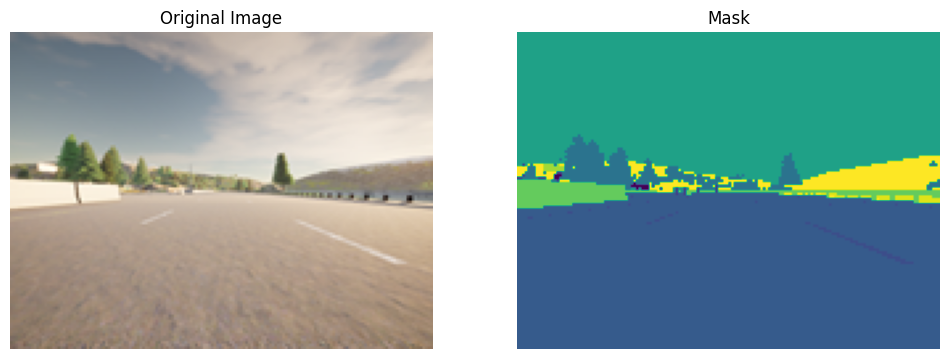

In [142]:
image_index = 0

original_image = image_dataset[image_index]
mask_image = mask_dataset[image_index]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image")
ax[0].axis('off')

ax[1].imshow(mask_image)
ax[1].set_title("Mask")
ax[1].axis('off')

plt.show()

In [143]:
#Encode labels to 0, 1, 2, 3, ... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
print(mask_dataset.shape)
n, h, w = mask_dataset.shape
mask_dataset_reshaped = mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

(265, 120, 160)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [144]:
#after label encoding
print("Now the labels in the mask are : ", np.unique(mask_dataset_encoded))

Now the labels in the mask are :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


In [145]:
#to match the size of the mask dataset with image dataset
mask_dataset_encoded = np.expand_dims(mask_dataset_encoded, axis = 3)
print(mask_dataset_encoded.shape)

(265, 120, 160, 1)


In [146]:
#Normalize images
image_dataset = image_dataset /255.

In [147]:
#Split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = my_seed)

In [148]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [149]:
print(y_train_cat.shape)

(212, 120, 160, 22)


In [150]:
print(y_test_cat.shape)

(53, 120, 160, 22)


<h1>Model creation, training and accuracy score</h1>

Since our input images are 120x160 in height and width, max pooling process should be compatible with the dimensions. If we use 2x2 filter for max pool convolution, we cannot do the process more than three times because 120 cannot be divided by two more than three times.

In [105]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

    b1 = conv_block(p3, 1024) #Bridge

    d2 = decoder_block(b1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [106]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)

(120, 160, 3)


In [107]:
model = build_unet(input_shape, n_classes=n_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

softmax
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 120, 160, 3)]        0         []                            
                                                                                                  
 conv2d_45 (Conv2D)          (None, 120, 160, 64)         1792      ['input_4[0][0]']             
                                                                                                  
 batch_normalization_42 (Ba  (None, 120, 160, 64)         256       ['conv2d_45[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_42 (Activation)  (None, 120, 160, 64)         0         ['batch_normalizat

In [108]:
history = model.fit(X_train, y_train_cat,
                    batch_size = 16,
                    epochs=90,
                    validation_data=(X_test, y_test_cat),
                    shuffle=False)

Epoch 1/90
14/14 [==============================] - 14s 350ms/step - loss: 1.7726 - accuracy: 0.6469 - val_loss: 2.7271 - val_accuracy: 0.4695
Epoch 2/90
14/14 [==============================] - 4s 305ms/step - loss: 0.8602 - accuracy: 0.8476 - val_loss: 4.4747 - val_accuracy: 0.5072
Epoch 3/90
14/14 [==============================] - 4s 291ms/step - loss: 0.6281 - accuracy: 0.8712 - val_loss: 7.0117 - val_accuracy: 0.3560
Epoch 4/90
14/14 [==============================] - 4s 314ms/step - loss: 0.5109 - accuracy: 0.8840 - val_loss: 3.7839 - val_accuracy: 0.4021
Epoch 5/90
14/14 [==============================] - 4s 292ms/step - loss: 0.4434 - accuracy: 0.8930 - val_loss: 2.7267 - val_accuracy: 0.4990
Epoch 6/90
14/14 [==============================] - 4s 314ms/step - loss: 0.4022 - accuracy: 0.8970 - val_loss: 1.7308 - val_accuracy: 0.6768
Epoch 7/90
14/14 [==============================] - 4s 308ms/step - loss: 0.3704 - accuracy: 0.9034 - val_loss: 2.1669 - val_accuracy: 0.6382
Epoch

In [109]:
#Save the model for future use
model.save('/content/drive/MyDrive/CENG506_HW3/90_epoch_RGB.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


I think the training and test accuracies are satisfactory after 90 epochs. Loss and accuracy graphs are below.

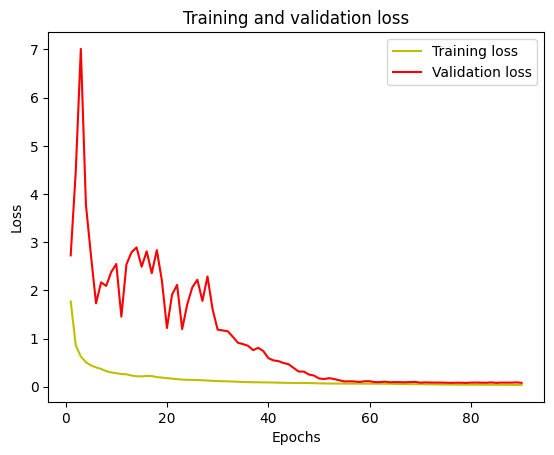

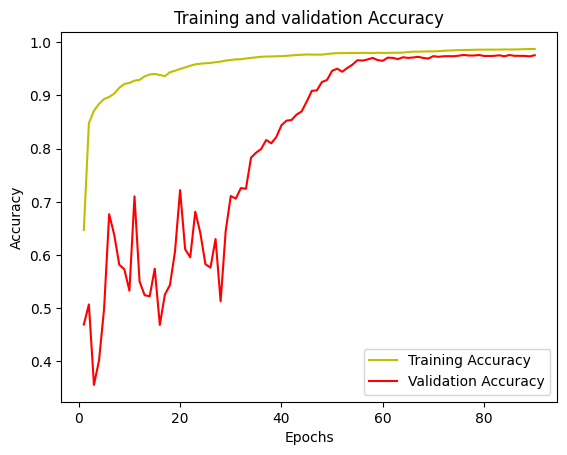

In [110]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<h1>Mean IoU</h1>

In [111]:
#Load previously saved model
from keras.models import load_model
model = load_model("/content/drive/MyDrive/CENG506_HW3/90_epoch_RGB.hdf5", compile=False)

In [112]:
y_pred=model.predict(X_test)

2/2 [==============================] - 0s 191ms/step


In [113]:
# line below selects the highest score class for every pixel and writes it to one matrix (y_pred_argmax)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

(53, 120, 160)

In [114]:
#Using built in keras function
from keras.metrics import MeanIoU

IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.65071374


<h1>Displaying sample images</h1>

1/1 [==============================] - 0s 17ms/step


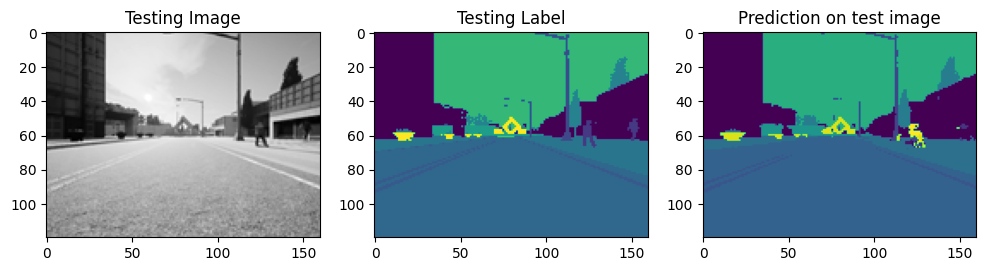

In [115]:
import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

In [161]:
def display_sample(number_of_sample):
    test_img_number = number_of_sample
    test_img = X_test[test_img_number]
    ground_truth = y_test[test_img_number]
    test_img_input = np.expand_dims(test_img, 0)
    prediction = model.predict(test_img_input)
    predicted_img = np.argmax(prediction, axis=3)[0,:,:]

    test_img_rgb = test_img[:, :, ::-1]  # Swap B and R channels

    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img_rgb)
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0])
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img)
    plt.show()

1/1 [==============================] - 0s 29ms/step


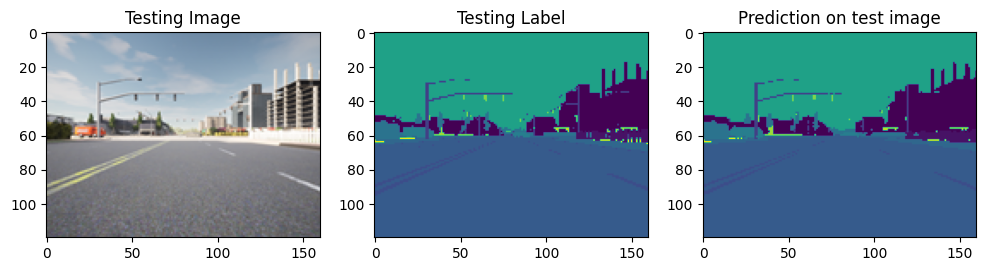

1/1 [==============================] - 0s 19ms/step


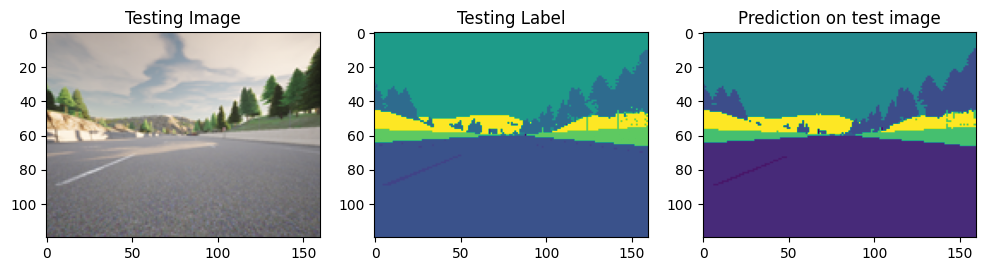

1/1 [==============================] - 0s 19ms/step


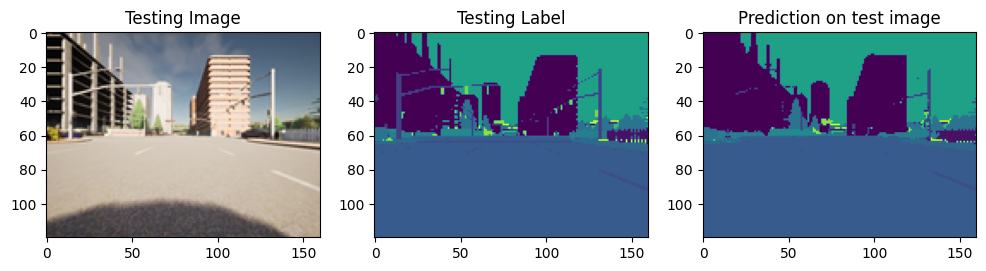

1/1 [==============================] - 0s 20ms/step


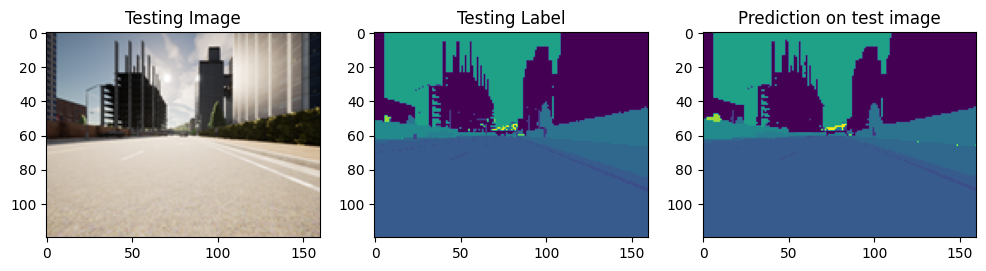

1/1 [==============================] - 0s 26ms/step


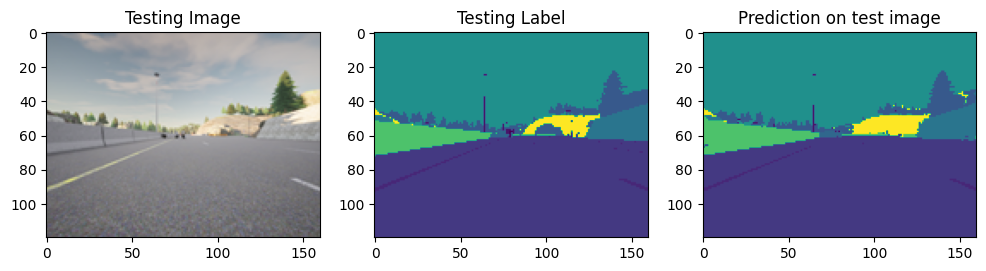

In [163]:
for i in range(5):
  display_sample(i)

Reference for code snippets I used: CENG506_Multiclass_Semantic_Segmentation.ipynb, Python notebook we used in the class